In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import timeline_drawer
import time

from qiskit.transpiler import InstructionDurations

import numpy as np
from qiskit_experiments.library import randomized_benchmarking as rb
from qiskit_experiments.framework import ParallelExperiment, BatchExperiment
from qiskit_experiments.library.randomized_benchmarking import RBUtils
from qiskit_experiments.library import StandardRB, InterleavedRB
import qiskit.circuit.library as circuits
from qiskit.circuit import Delay, Instruction
from qiskit.circuit.library.standard_gates import RXXGate, RZZGate, RZXGate, XGate, SXGate, IGate, CCXGate, SGate, CXGate
from datetime import datetime
from qiskit_experiments.library.randomized_benchmarking.double_interleaved_rb_experiment import DoubleInterleavedRB


In [2]:
from qiskit import IBMQ
IBMQ.load_account()
IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='qamp', project='spring-22-17')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='qamp', project='spring-22-17-2')>,
 <AccountProvider for IBMQ(hub='ibm-q-skku', group='internal', project='reservations')>,
 <AccountProvider for IBMQ(hub='ibm-q-skku', group='skku', project='squirl')>,
 <AccountProvider for IBMQ(hub='ibm-q-skku', group='skku', project='skku-graduate')>,
 <AccountProvider for IBMQ(hub='qc-spring-22-4', group='group-4', project='recdZ7NwFc2tUZtMH')>]

In [4]:
provider=IBMQ.providers()[-1]
#provider = IBMQ.get_provider(hub='ibm-q-community', group='qamp', project='spring-22-17')
#backend=provider.backend.ibmq_lima
backend = provider.get_backend('ibm_nairobi')

# get the basic feautures including qubit number of the backend.
config = backend.configuration()
backend_job_limit=backend.job_limit()

print("{0} is on version {1}. It has {2} qubit{3}. It "
      "{4} OpenPulse programs. The basis gates supported on this device are {5}.{6} are the list of connected qubits."
      "{7} can handle maximum {8} circuits(experiments) per job."
      "Maximum number of active job i can have on it (cocurrent jobs that a user is able to submit to a backend) is {9}."
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates,
                config.coupling_map,
               config.backend_name,
               config.max_experiments,
               backend_job_limit.maximum_jobs))

ibm_nairobi is on version 1.0.20. It has 7 qubits. It does not support OpenPulse programs. The basis gates supported on this device are ['id', 'rz', 'sx', 'x', 'cx', 'reset'].[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 5], [4, 5], [5, 3], [5, 4], [5, 6], [6, 5]] are the list of connected qubits.ibm_nairobi can handle maximum 300 circuits(experiments) per job.Maximum number of active job i can have on it (cocurrent jobs that a user is able to submit to a backend) is None.


In [5]:
backend.properties().gate_length('cx',(1,2))/backend.properties().gate_length('x',(0))


12.0

In [7]:
def run_2qdelay_cx_irb(
    backend,
    qubits,
    lengths,
    num_samples=10,
    shots=1000,
    seed=2022,
):
    print(f"----Experiment starts at {datetime.today()}----")
    print(f"Backend: {backend.name()}, Qubits: {qubits}")

    cx_duration = round(backend.properties().gate_length('cx', qubits) / backend.configuration().dt)
    delay_qc = QuantumCircuit(2)
    delay_qc.delay(cx_duration, [0, 1], unit="dt")
                                                          
    dirb = DoubleInterleavedRB(
        first_interleaved_op=delay_qc,
        second_interleaved_op=CXGate(),
        qubits=qubits,
        lengths=lengths,
        num_samples=num_samples,
        seed=seed
    )
    dirb.set_transpile_options(scheduling_method='asap')
    expdata = dirb.run(backend, shots=shots).block_for_results()
    display(expdata.figure(0))
 
    cle = RBUtils.coherence_limit(2,
                                  T1_list=[backend.properties().t1(q) for q in qubits], 
                                  T2_list=[min(backend.properties().t2(q), 2*backend.properties().t1(q)) for q in qubits],
                                  gatelen=backend.properties().gate_length('cx', qubits))
    print(f"Coherence limit error: {cle:.6f}")
    print(f"2q-delay (wo DD) error (IRB): {expdata.analysis_results('EPC1').value}")
    print(f"CX gate error (IRB): {expdata.analysis_results('EPC2').value}")
    print(f"Ref: Reported CX error: {backend.properties().gate_error('cx', qubits):.6f}")
    print(f"----Experiment finishes at {datetime.today()}----")

In [5]:
def run_2qdelay_dd_irb(
    backend,
    qubits,
    lengths,
    num_samples=10,
    shots=1000,
    seed=2022,
):
    print(f"----Experiment starts at {datetime.today()}----")
    print(f"Backend: {backend.name()}, Qubits: {qubits}")

    cx_duration = round(backend.properties().gate_length('cx', qubits) / backend.configuration().dt)
    x_duration = round(backend.properties().gate_length('x', qubits[0]) / backend.configuration().dt)
    dd_duration = (cx_duration - 2 * x_duration) // 4
    mid_duration = 2 * dd_duration
    residual = dd_duration % 16
    if residual != 0:
        dd_duration -= residual
        mid_duration += 2 * residual
        
    #print(f"cx_duration={cx_duration}[dt], x_duration={x_duration}[dt], dd_duration={dd_duration}[dt]")

    delay_qc = QuantumCircuit(2)
    delay_qc.delay(cx_duration, [0, 1], unit="dt")

    num_x=backend.properties().gate_length('cx',(1,2))/backend.properties().gate_length('x',(0))
    dd_qc = QuantumCircuit(2)
    for i in range(int(num_x)):
        dd_qc.x(0)
        dd_qc.x(1)
                                                      
    dirb = DoubleInterleavedRB(
        first_interleaved_op=delay_qc,
        second_interleaved_op=dd_qc,
        qubits=qubits,
        lengths=lengths,
        num_samples=num_samples,
        seed=seed
    )
#     dirb.set_transpile_options(scheduling_method='asap')
    expdata = dirb.run(backend, shots=shots).block_for_results()
    display(expdata.figure(0))
#     for result in expdata.analysis_results():
#         print(result)

    # cle = RBUtils.coherence_limit_error(2, backend.properties().gate_length('cx', qubits),
    #                                     t1s=[backend.properties().t1(q) for q in qubits], 
    #                                     t2s=[min(backend.properties().t2(q), 2*backend.properties().t1(q)) for q in qubits])
    cle = RBUtils.coherence_limit(2,
                                  T1_list=[backend.properties().t1(q) for q in qubits], 
                                  T2_list=[min(backend.properties().t2(q), 2*backend.properties().t1(q)) for q in qubits],
                                  gatelen=backend.properties().gate_length('cx', qubits))
    print(f"Coherence limit error: {cle:.6f}")
    print(f"2q-delay (wo DD) error (IRB): {expdata.analysis_results('EPC1').value}")
    print(f"2q-delay with DD error (IRB): {expdata.analysis_results('EPC2').value}")
    print(f"Ref: Reported CX error: {backend.properties().gate_error('cx', qubits):.6f}")
    print(f"----Experiment finishes at {datetime.today()}----")

# nairobi_q4,5
#### delay>CX

----Experiment starts at 2022-06-13 21:42:52.043341----
Backend: ibm_nairobi, Qubits: [4, 5]


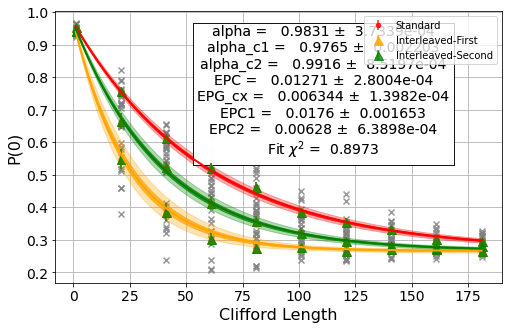

Coherence limit error: 0.004746
2q-delay (wo DD) error (IRB): 0.0176+/-0.0017
CX gate error (IRB): 0.0063+/-0.0006
Ref: Reported CX error: 0.005697
----Experiment finishes at 2022-06-13 21:50:40.613609----


In [8]:
run_2qdelay_cx_irb(
    backend,
    qubits=[4,5],
    lengths=np.arange(1, 200, 20),
    num_samples=10,
    shots=1000,
)

# nairobi_q1,2
Try X*12
#### 2qDelay>2qDelay+DD>CX

----Experiment starts at 2022-06-13 22:36:15.272822----
Backend: ibm_nairobi, Qubits: [1, 2]


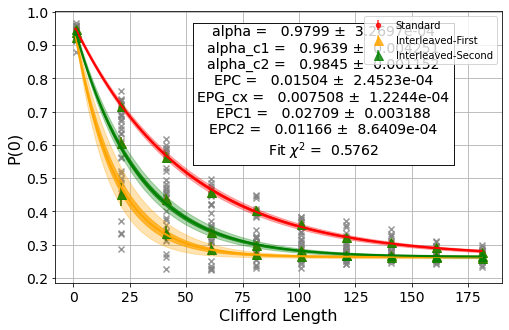

Coherence limit error: 0.004264
2q-delay (wo DD) error (IRB): 0.0271+/-0.0032
CX gate error (IRB): 0.0117+/-0.0009
Ref: Reported CX error: 0.008088
----Experiment finishes at 2022-06-13 22:42:22.837194----


In [9]:
run_2qdelay_cx_irb(
    backend,
    qubits=[1,2],
    lengths=np.arange(1, 200, 20),
    num_samples=10,
    shots=1000,
)

----Experiment starts at 2022-06-10 16:51:48.188802----
Backend: ibm_nairobi, Qubits: [1, 2]


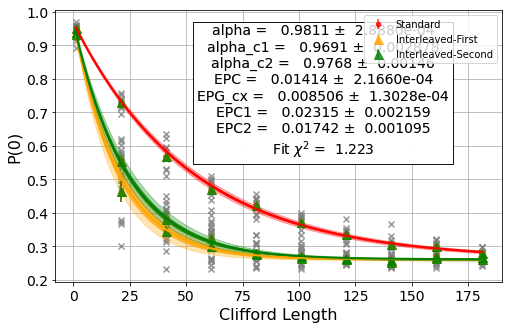

Coherence limit error: 0.003813
2q-delay (wo DD) error (IRB): 0.0231+/-0.0022
2q-delay with DD error (IRB): 0.0174+/-0.0011
Ref: Reported CX error: 0.006335
----Experiment finishes at 2022-06-10 16:59:37.525352----


In [32]:
run_2qdelay_dd_irb(
    backend,
    qubits=[1,2],
    lengths=np.arange(1, 200, 20),
    num_samples=10,
    shots=1000,
)

----Experiment starts at 2022-06-10 16:38:14.179507----
Backend: ibm_nairobi, Qubits: [3, 5]


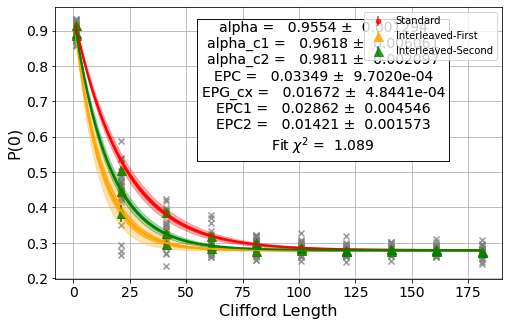

Coherence limit error: 0.005382
Ref: Reported CX error: 0.016688
----Experiment finishes at 2022-06-10 16:44:25.411615----


In [29]:
run_2qdelay_cx_irb(
    backend,
    qubits=[3,5],
    lengths=np.arange(1, 200, 20),
    num_samples=10,
    shots=1000,
)

ibm_nairobi
DD on q1q2
2022-06-10 15:48:59.083819


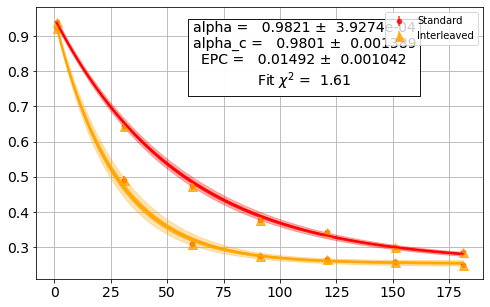

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.6960454813247259, 0.98213081689495, 0.9801103907941435, 0.2541148202836942]
- χ²: 1.6103251522688726
- quality: good
- extra: <4 items>
- device_components: ['Q1', 'Q2']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9821+/-0.0004
- χ²: 1.6103251522688726
- quality: good
- extra: <1 items>
- device_components: ['Q1', 'Q2']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9801+/-0.0014
- χ²: 1.6103251522688726
- quality: good
- extra: <1 items>
- device_components: ['Q1', 'Q2']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0149+/-0.0010
- χ²: 1.6103251522688726
- quality: good
- extra: <3 items>
- device_components: ['Q1', 'Q2']
- verified: False


In [21]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [1,2]
print(backend)
print('DD on q1q2')
print(datetime.today())

duration=backend.properties().gate_length('cx',(1,2))/backend.configuration().dt
dd_qc = QuantumCircuit(2)
for i in range(int(num_x)):
    dd_qc.x(0)
    dd_qc.x(1)
int_exp2 = InterleavedRB(
    interleaved_element=dd_qc, qubits=[1,2], lengths=lengths, num_samples=num_samples, seed=seed)
int_exp2.set_transpile_options(scheduling_method='asap')
# Run
int_expdata2 = int_exp2.run(backend, shots=1000).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)

ibm_nairobi
2q Delay on q1q2
2022-06-10 15:56:17.499460


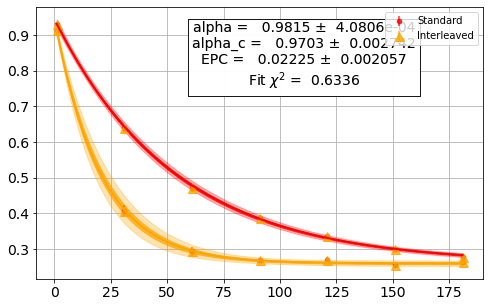

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.684899078570606, 0.9814503030876505, 0.9703376224429334, 0.2596918622897724]
- χ²: 0.6335598323478269
- quality: good
- extra: <4 items>
- device_components: ['Q1', 'Q2']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9815+/-0.0004
- χ²: 0.6335598323478269
- quality: good
- extra: <1 items>
- device_components: ['Q1', 'Q2']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9703+/-0.0027
- χ²: 0.6335598323478269
- quality: good
- extra: <1 items>
- device_components: ['Q1', 'Q2']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0222+/-0.0021
- χ²: 0.6335598323478269
- quality: good
- extra: <3 items>
- device_components: ['Q1', 'Q2']
- verified: False


In [22]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [1,2]
print(backend)
print('2q Delay on q1q2')
print(datetime.today())

duration=backend.properties().gate_length('cx',(1,2))/backend.configuration().dt
delay_qc = QuantumCircuit(2)
delay_qc.delay(round(duration), [0], unit="dt")
delay_qc.delay(round(duration), [1], unit="dt")
int_exp2 = InterleavedRB(
    interleaved_element=delay_qc, qubits=[1,2], lengths=lengths, num_samples=num_samples, seed=seed)
int_exp2.set_transpile_options(scheduling_method='asap')
# Run
int_expdata2 = int_exp2.run(backend, shots=1000).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)

ibm_nairobi
CXGate
2022-06-10 16:05:56.243494


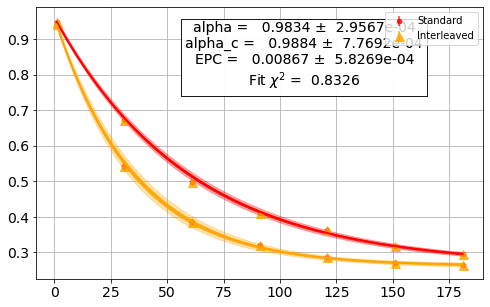

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.6975348859331149, 0.983424293217125, 0.9884394245994774, 0.26223030072413966]
- χ²: 0.832601229058605
- quality: good
- extra: <4 items>
- device_components: ['Q1', 'Q2']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.98342+/-0.00030
- χ²: 0.832601229058605
- quality: good
- extra: <1 items>
- device_components: ['Q1', 'Q2']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9884+/-0.0008
- χ²: 0.832601229058605
- quality: good
- extra: <1 items>
- device_components: ['Q1', 'Q2']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0087+/-0.0006
- χ²: 0.832601229058605
- quality: good
- extra: <3 items>
- device_components: ['Q1', 'Q2']
- verified: False


In [23]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [1,2]
print(backend)
print('CXGate')
print(datetime.today())

int_exp2 = InterleavedRB(
    circuits.CXGate(), qubits, lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata2 = int_exp2.run(backend).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)

# nairobi_q4,5
- CLE(0.002726)<CX(0.009568)<2qDealy(0.01973)

In [4]:
date= datetime.today()
qubit='nairobi_q45'
nairobi_q45=RBUtils.coherence_limit_error(2, 
backend.properties().gate_length('cx',(4,5)),
 t1s=[backend.properties().t1(4),backend.properties().t1(5)], 
 t2s=[backend.properties().t1(4),backend.properties().t1(5)])
print(f'{qubit} CLE is {nairobi_q45} on {date}')

nairobi_q45 CLE is 0.0027267824762555294 on 2022-05-30 11:11:13.535968


ibm_nairobi
CXGate
2022-05-28 15:35:23.934850


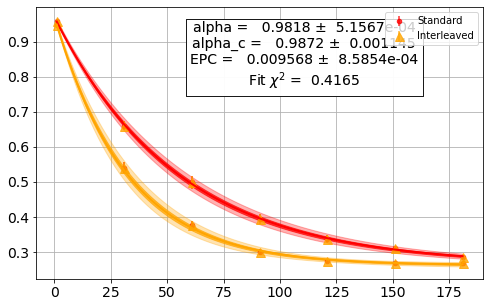

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.7073914871491273, 0.981838183559896, 0.987243189403549, 0.26227682413678954]
- χ²: 0.4164772807443648
- quality: good
- extra: <4 items>
- device_components: ['Q4', 'Q5']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9818+/-0.0005
- χ²: 0.4164772807443648
- quality: good
- extra: <1 items>
- device_components: ['Q4', 'Q5']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9872+/-0.0011
- χ²: 0.4164772807443648
- quality: good
- extra: <1 items>
- device_components: ['Q4', 'Q5']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0096+/-0.0009
- χ²: 0.4164772807443648
- quality: good
- extra: <3 items>
- device_components: ['Q4', 'Q5']
- verified: False


In [10]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [4,5]
print(backend)
print('CXGate')
print(datetime.today())

int_exp2 = InterleavedRB(
    circuits.CXGate(), qubits, lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata2 = int_exp2.run(backend).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)

ibm_nairobi
2q Delay
2022-05-28 15:23:31.548325
1407.9999999999998


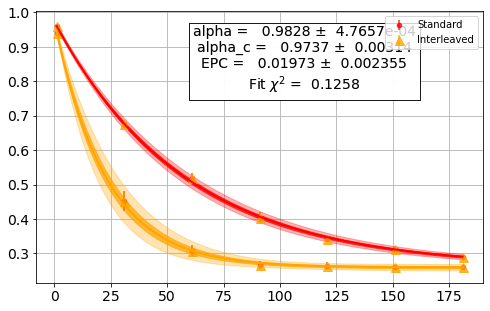

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.7127872456441702, 0.9828123770409474, 0.9736937551901407, 0.2595566108261873]
- χ²: 0.12580770027745108
- quality: good
- extra: <4 items>
- device_components: ['Q4', 'Q5']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9828+/-0.0005
- χ²: 0.12580770027745108
- quality: good
- extra: <1 items>
- device_components: ['Q4', 'Q5']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9737+/-0.0031
- χ²: 0.12580770027745108
- quality: good
- extra: <1 items>
- device_components: ['Q4', 'Q5']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0197+/-0.0024
- χ²: 0.12580770027745108
- quality: good
- extra: <3 items>
- device_components: ['Q4', 'Q5']
- verified: False


In [8]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [4,5]
print(backend)
print('2q Delay')
print(datetime.today())

duration=backend.properties().gate_length('cx',(4,5))/backend.configuration().dt
delay_qc = QuantumCircuit(2)
delay_qc.delay(round(duration), [0], unit="dt")
delay_qc.delay(round(duration), [1], unit="dt")
int_exp2 = InterleavedRB(
    interleaved_element=delay_qc, qubits=[4,5], lengths=lengths, num_samples=num_samples, seed=seed)
int_exp2.set_transpile_options(scheduling_method='asap')
# Run
int_expdata2 = int_exp2.run(backend, shots=1000).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)

# nairobi_q0,1
- CLE(0.00217)<CX(0.008)<2qDelay(0.02001)

In [5]:
date= datetime.today()
qubit='nairobi_q01'
nairobi_q01=RBUtils.coherence_limit_error(2, 
backend.properties().gate_length('cx',(0,1)),
 t1s=[backend.properties().t1(0),backend.properties().t1(1)], 
 t2s=[backend.properties().t1(0),backend.properties().t1(1)])
print(f'{qubit} CLE is {nairobi_q01} on {date}')

nairobi_q01 CLE is 0.0021790257749925604 on 2022-05-29 20:35:17.162370


ibm_nairobi
belem_q1,2
reported CXerror at 2022-05-29 20:36:04.423651 is 0.008720449560030236
2022-05-29 20:36:05.219179


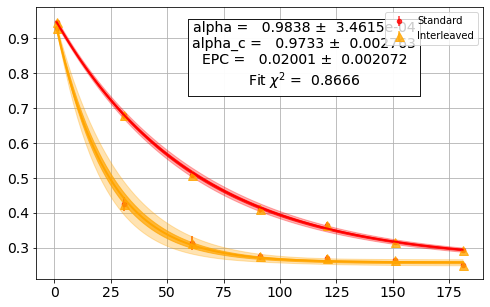

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.6991369768299692, 0.9837909337115686, 0.9733169006746198, 0.2580035430636713]
- χ²: 0.866607364075254
- quality: good
- extra: <4 items>
- device_components: ['Q1', 'Q2']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.98379+/-0.00035
- χ²: 0.866607364075254
- quality: good
- extra: <1 items>
- device_components: ['Q1', 'Q2']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9733+/-0.0028
- χ²: 0.866607364075254
- quality: good
- extra: <1 items>
- device_components: ['Q1', 'Q2']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0200+/-0.0021
- χ²: 0.866607364075254
- quality: good
- extra: <3 items>
- device_components: ['Q1', 'Q2']
- verified: False
0.007816587242891693


In [4]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [1,2]
date= datetime.today()
CXerror=backend.properties().gate_error('cx',(0,1))
print(backend)
print('nairobi_q1,2')
print(f"reported CXerror at {date} is {CXerror}")
print(datetime.today())

duration=backend.properties().gate_length('cx',(1,2))/backend.configuration().dt
delay_qc = QuantumCircuit(2)
delay_qc.delay(round(duration), [0], unit="dt")
delay_qc.delay(round(duration), [1], unit="dt")
int_exp2 = InterleavedRB(
    interleaved_element=delay_qc, qubits=[1,2], lengths=lengths, num_samples=num_samples, seed=seed)
int_exp2.set_transpile_options(scheduling_method='asap')
# Run
int_expdata2 = int_exp2.run(backend, shots=1000).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)
print(backend.properties().gate_error('cx',(1,2)))

# nairobi_q5,6

In [5]:
date=datetime.today()
CLE=RBUtils.coherence_limit(nQ=2, 
T1_list=[backend.properties().t1(5),backend.properties().t1(6)],
T2_list=[backend.properties().t2(5),backend.properties().t2(6)], 
gatelen=backend.properties().gate_length('cx',(5,6)))
print(f"CLE is {CLE} at {date}")

CLE is 0.0038438707240550374 at 2022-06-03 16:54:30.767631


ibm_nairobi
nairobi_q5,6
reported CXerror at 2022-06-03 16:55:09.804733 is 0.007319452659149017
2022-06-03 16:55:09.805733


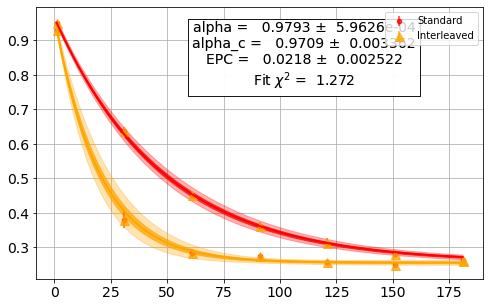

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.7092510206788373, 0.9792883972770414, 0.9709310161534311, 0.25630289539924056]
- χ²: 1.2717008815181612
- quality: good
- extra: <4 items>
- device_components: ['Q5', 'Q6']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9793+/-0.0006
- χ²: 1.2717008815181612
- quality: good
- extra: <1 items>
- device_components: ['Q5', 'Q6']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9709+/-0.0034
- χ²: 1.2717008815181612
- quality: good
- extra: <1 items>
- device_components: ['Q5', 'Q6']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0218+/-0.0025
- χ²: 1.2717008815181612
- quality: good
- extra: <3 items>
- device_components: ['Q5', 'Q6']
- verified: False
0.007319452659149017
CLE is or nairobi_q56 is 0.0038438707240550374 at 2022-06-03 16:55:09.804733


In [6]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [5,6]
date= datetime.today()
CXerror=backend.properties().gate_error('cx',(5,6))
print(backend)
print('nairobi_q5,6')
print(f"reported CXerror at {date} is {CXerror}")
print(datetime.today())

duration=backend.properties().gate_length('cx',(5,6))/backend.configuration().dt
delay_qc = QuantumCircuit(2)
delay_qc.delay(round(duration), [0], unit="dt")
delay_qc.delay(round(duration), [1], unit="dt")
int_exp2 = InterleavedRB(
    interleaved_element=delay_qc, qubits=[5,6], lengths=lengths, num_samples=num_samples, seed=seed)
int_exp2.set_transpile_options(scheduling_method='asap')
# Run
int_expdata2 = int_exp2.run(backend, shots=1000).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)
print(backend.properties().gate_error('cx',(5,6)))

qubit='nairobi_q56'
CLE=RBUtils.coherence_limit(nQ=2, 
T1_list=[backend.properties().t1(5),backend.properties().t1(6)],
T2_list=[backend.properties().t2(5),backend.properties().t2(6)], 
gatelen=backend.properties().gate_length('cx',(5,6)))
print(f"CLE is or {qubit} is{CLE} at {date}")


ibm_nairobi
CXGate on q5,6
2022-06-03 17:14:14.575891


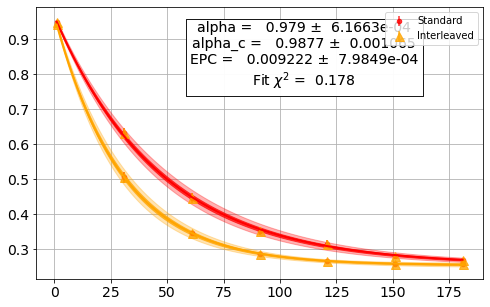

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.7087164222157486, 0.9789555817400482, 0.987703453656013, 0.25499037574871597]
- χ²: 0.17798113994806664
- quality: good
- extra: <4 items>
- device_components: ['Q5', 'Q6']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9790+/-0.0006
- χ²: 0.17798113994806664
- quality: good
- extra: <1 items>
- device_components: ['Q5', 'Q6']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9877+/-0.0011
- χ²: 0.17798113994806664
- quality: good
- extra: <1 items>
- device_components: ['Q5', 'Q6']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0092+/-0.0008
- χ²: 0.17798113994806664
- quality: good
- extra: <3 items>
- device_components: ['Q5', 'Q6']
- verified: False


In [10]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [5,6]
print(backend)
print('CXGate on q5,6')
print(datetime.today())

int_exp2 = InterleavedRB(
    circuits.CXGate(), qubits, lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata2 = int_exp2.run(backend).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)

# nairobi_q3,5

In [ ]:
date=datetime.today()
CLE=RBUtils.coherence_limit(nQ=2, 
T1_list=[backend.properties().t1(5),backend.properties().t1(6)],
T2_list=[backend.properties().t2(5),backend.properties().t2(6)], 
gatelen=backend.properties().gate_length('cx',(5,6)))
print(f"CLE is {CLE} at {date}")

ibm_nairobi
nairobi_q3,5
reported CXerror at 2022-06-03 17:05:35.246576 is 0.01632645574894287
2022-06-03 17:05:35.246576


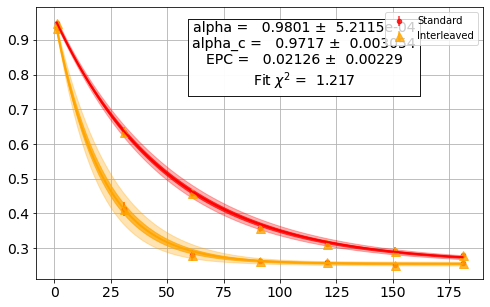

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.7086034774840434, 0.9801157274447752, 0.971652930232399, 0.2551340786203179]
- χ²: 1.21724961232565
- quality: good
- extra: <4 items>
- device_components: ['Q5', 'Q6']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9801+/-0.0005
- χ²: 1.21724961232565
- quality: good
- extra: <1 items>
- device_components: ['Q5', 'Q6']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9717+/-0.0031
- χ²: 1.21724961232565
- quality: good
- extra: <1 items>
- device_components: ['Q5', 'Q6']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0213+/-0.0023
- χ²: 1.21724961232565
- quality: good
- extra: <3 items>
- device_components: ['Q5', 'Q6']
- verified: False
0.01632645574894287
CLE is or nairobi_q35 is 0.0035615117504463334 at 2022-06-03 17:05:35.246576


In [7]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [3,5]
date= datetime.today()
CXerror=backend.properties().gate_error('cx',(3,5))
print(backend)
print('nairobi_q3,5')
print(f"reported CXerror at {date} is {CXerror}")
print(datetime.today())

duration=backend.properties().gate_length('cx',(3,5))/backend.configuration().dt
delay_qc = QuantumCircuit(2)
delay_qc.delay(round(duration), [0], unit="dt")
delay_qc.delay(round(duration), [1], unit="dt")
int_exp2 = InterleavedRB(
    interleaved_element=delay_qc, qubits=[5,6], lengths=lengths, num_samples=num_samples, seed=seed)
int_exp2.set_transpile_options(scheduling_method='asap')
# Run
int_expdata2 = int_exp2.run(backend, shots=1000).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)
print(backend.properties().gate_error('cx',(3,5)))

qubit='nairobi_q35'
CLE=RBUtils.coherence_limit(nQ=2, 
T1_list=[backend.properties().t1(3),backend.properties().t1(5)],
T2_list=[backend.properties().t2(3),backend.properties().t2(5)], 
gatelen=backend.properties().gate_length('cx',(3,5)))
print(f"CLE is or {qubit} is {CLE} at {date}")

ibm_nairobi
CXGate on q3,5
2022-06-03 17:19:54.013096


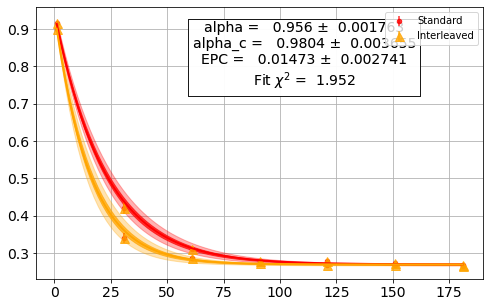

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.6742438868267886, 0.9560449286437629, 0.9803585257072438, 0.2689820630546883]
- χ²: 1.9522075758108453
- quality: good
- extra: <4 items>
- device_components: ['Q3', 'Q5']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9560+/-0.0018
- χ²: 1.9522075758108453
- quality: good
- extra: <1 items>
- device_components: ['Q3', 'Q5']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.980+/-0.004
- χ²: 1.9522075758108453
- quality: good
- extra: <1 items>
- device_components: ['Q3', 'Q5']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0147+/-0.0027
- χ²: 1.9522075758108453
- quality: good
- extra: <3 items>
- device_components: ['Q3', 'Q5']
- verified: False


In [11]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [3,5]
print(backend)
print('CXGate on q3,5')
print(datetime.today())

int_exp2 = InterleavedRB(
    circuits.CXGate(), qubits, lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata2 = int_exp2.run(backend).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)

# nairobi_q1,3

ibm_nairobi
nairobi_q1,3
reported CXerror at 2022-06-03 17:27:12.115263 is 0.008121725287829173
2022-06-03 17:27:12.116266


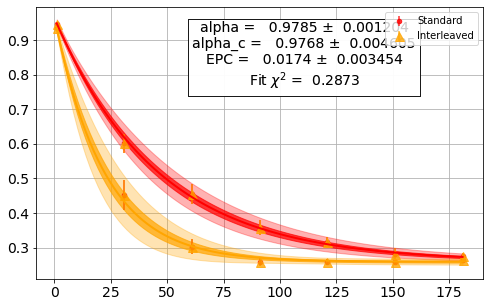

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.7037541262064155, 0.9784640732317628, 0.9767943417183711, 0.2593038946571501]
- χ²: 0.28728335013393697
- quality: good
- extra: <4 items>
- device_components: ['Q1', 'Q3']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9785+/-0.0012
- χ²: 0.28728335013393697
- quality: good
- extra: <1 items>
- device_components: ['Q1', 'Q3']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.977+/-0.005
- χ²: 0.28728335013393697
- quality: good
- extra: <1 items>
- device_components: ['Q1', 'Q3']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0174+/-0.0035
- χ²: 0.28728335013393697
- quality: good
- extra: <3 items>
- device_components: ['Q1', 'Q3']
- verified: False
0.008121725287829173
CLE is or nairobi_q13 is 0.0025607702228711837 at 2022-06-03 17:27:12.115263


In [12]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [1,13]
date= datetime.today()
CXerror=backend.properties().gate_error('cx',(1,3))
print(backend)
print('nairobi_q1,3')
print(f"reported CXerror at {date} is {CXerror}")
print(datetime.today())

duration=backend.properties().gate_length('cx',(1,3))/backend.configuration().dt
delay_qc = QuantumCircuit(2)
delay_qc.delay(round(duration), [0], unit="dt")
delay_qc.delay(round(duration), [1], unit="dt")
int_exp2 = InterleavedRB(
    interleaved_element=delay_qc, qubits=[1,3], lengths=lengths, num_samples=num_samples, seed=seed)
int_exp2.set_transpile_options(scheduling_method='asap')
# Run
int_expdata2 = int_exp2.run(backend, shots=1000).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)
print(backend.properties().gate_error('cx',(1,3)))

qubit='nairobi_q13'
CLE=RBUtils.coherence_limit(nQ=2, 
T1_list=[backend.properties().t1(3),backend.properties().t1(1)],
T2_list=[backend.properties().t2(3),backend.properties().t2(1)], 
gatelen=backend.properties().gate_length('cx',(1,3)))
print(f"CLE is or {qubit} is {CLE} at {date}")

ibm_nairobi
CXGate on q1,3
2022-06-03 17:29:59.709436


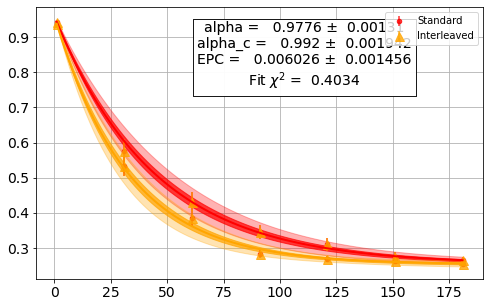

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.7067954482951974, 0.9776000853523003, 0.9919656077228225, 0.25301354742559384]
- χ²: 0.40343838488975703
- quality: good
- extra: <4 items>
- device_components: ['Q1', 'Q3']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9776+/-0.0013
- χ²: 0.40343838488975703
- quality: good
- extra: <1 items>
- device_components: ['Q1', 'Q3']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9920+/-0.0019
- χ²: 0.40343838488975703
- quality: good
- extra: <1 items>
- device_components: ['Q1', 'Q3']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0060+/-0.0015
- χ²: 0.40343838488975703
- quality: good
- extra: <3 items>
- device_components: ['Q1', 'Q3']
- verified: False


In [13]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [1,3]
print(backend)
print('CXGate on q1,3')
print(datetime.today())

int_exp2 = InterleavedRB(
    circuits.CXGate(), qubits, lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata2 = int_exp2.run(backend).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)

# nairobi_q0,1

ibm_nairobi
nairobi_q0,1
reported CXerror at 2022-06-03 17:38:01.001541 is 0.008441688785055246
2022-06-03 17:38:01.001541


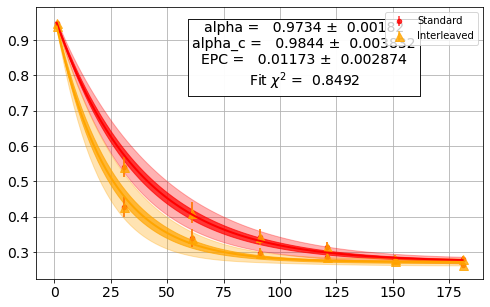

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.6945912926509628, 0.9734169803667247, 0.9843573557922898, 0.27174527418651584]
- χ²: 0.8491656002645147
- quality: good
- extra: <4 items>
- device_components: ['Q0', 'Q1']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9734+/-0.0018
- χ²: 0.8491656002645147
- quality: good
- extra: <1 items>
- device_components: ['Q0', 'Q1']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.984+/-0.004
- χ²: 0.8491656002645147
- quality: good
- extra: <1 items>
- device_components: ['Q0', 'Q1']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0117+/-0.0029
- χ²: 0.8491656002645147
- quality: good
- extra: <3 items>
- device_components: ['Q0', 'Q1']
- verified: False
0.008441688785055246
CLE is or nairobi_q01 is 0.003329295939629495 at 2022-06-03 17:38:01.001541


In [15]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [1,0]
date= datetime.today()
CXerror=backend.properties().gate_error('cx',(0,1))
print(backend)
print('nairobi_q0,1')
print(f"reported CXerror at {date} is {CXerror}")
print(datetime.today())

duration=backend.properties().gate_length('cx',(0,1))/backend.configuration().dt
delay_qc = QuantumCircuit(2)
delay_qc.delay(round(duration), [0], unit="dt")
delay_qc.delay(round(duration), [1], unit="dt")
int_exp2 = InterleavedRB(
    interleaved_element=delay_qc, qubits=[0,1], lengths=lengths, num_samples=num_samples, seed=seed)
int_exp2.set_transpile_options(scheduling_method='asap')
# Run
int_expdata2 = int_exp2.run(backend, shots=1000).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)
print(backend.properties().gate_error('cx',(0,1)))

qubit='nairobi_q01'
CLE=RBUtils.coherence_limit(nQ=2, 
T1_list=[backend.properties().t1(0),backend.properties().t1(1)],
T2_list=[backend.properties().t2(0),backend.properties().t2(1)], 
gatelen=backend.properties().gate_length('cx',(0,1)))
print(f"CLE is or {qubit} is {CLE} at {date}")

ibm_nairobi
CXGate on q0,1
2022-06-03 17:40:44.221486


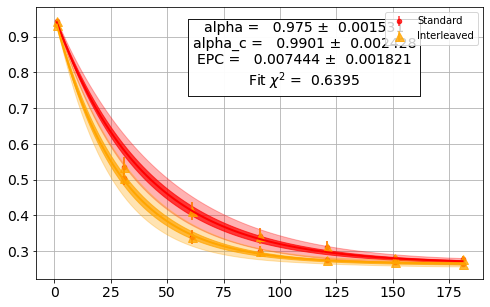

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.6935893667740183, 0.9750271093075197, 0.9900750678050846, 0.26420082968179714]
- χ²: 0.6395200752200334
- quality: good
- extra: <4 items>
- device_components: ['Q0', 'Q1']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9750+/-0.0015
- χ²: 0.6395200752200334
- quality: good
- extra: <1 items>
- device_components: ['Q0', 'Q1']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9901+/-0.0024
- χ²: 0.6395200752200334
- quality: good
- extra: <1 items>
- device_components: ['Q0', 'Q1']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0074+/-0.0018
- χ²: 0.6395200752200334
- quality: good
- extra: <3 items>
- device_components: ['Q0', 'Q1']
- verified: False


In [16]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [0,1]
print(backend)
print('CXGate on q0,1')
print(datetime.today())

int_exp2 = InterleavedRB(
    circuits.CXGate(), qubits, lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata2 = int_exp2.run(backend).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)

# 1q : D vs CLE


ibm_nairobi
delay_q1
2022-06-04 15:49:34.994063


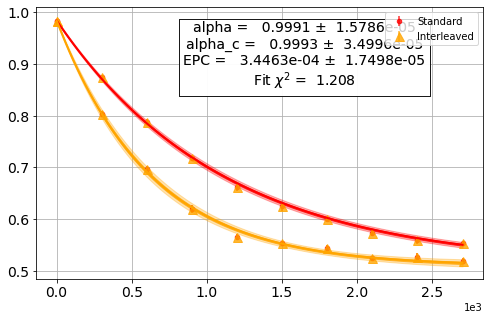

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.47512859584468625, 0.9990963433933178, 0.9993107332998056, 0.508724599234382]
- χ²: 1.2079801618783792
- quality: good
- extra: <4 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.999096+/-0.000016
- χ²: 1.2079801618783792
- quality: good
- extra: <1 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.999311+/-0.000035
- χ²: 1.2079801618783792
- quality: good
- extra: <1 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.000345+/-0.000017
- χ²: 1.2079801618783792
- quality: good
- extra: <3 items>
- device_components: ['Q0']
- verified: False
CLE is 0.000275938304931167 at 2022-06-04 16:01:21.685799


In [4]:
lengths = np.arange(1, 3000, 300)
num_samples = 10
seed = 1010
qubits = [0]
print(backend)
print('delay_q1')
print(datetime.today())

duration=backend.properties().gate_length('x',0)/backend.configuration().dt
interleaved_element = Delay(duration, unit="dt")
int_exp1 = InterleavedRB(interleaved_element, qubits, lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata1 = int_exp1.run(backend, shots=1000).block_for_results()
int_results1 = int_expdata1.analysis_results()
# View result data
display(int_expdata1.figure(0))
for result in int_results1:
    print(result)
date = datetime.today()
CLE=RBUtils.coherence_limit(nQ=1, T1_list=[backend.properties(datetime=date).t1(0)],
T2_list=[backend.properties(datetime=date).t2(0)], gatelen=backend.properties(datetime=date).gate_length('x',(0)))
print(f"CLE is {CLE} at {date}")

ibm_nairobi
delay_q1
2022-06-04 16:04:23.334706


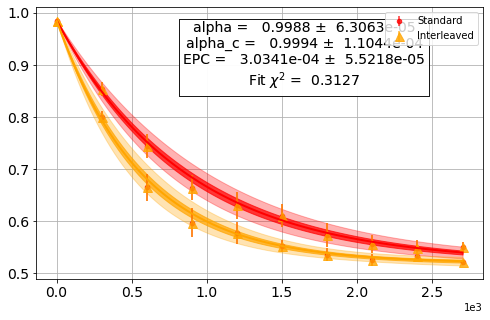

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.46595867939603425, 0.9988444365494104, 0.9993931843258146, 0.5195210474787202]
- χ²: 0.3127254107941943
- quality: good
- extra: <4 items>
- device_components: ['Q1']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.99884+/-0.00006
- χ²: 0.3127254107941943
- quality: good
- extra: <1 items>
- device_components: ['Q1']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.99939+/-0.00011
- χ²: 0.3127254107941943
- quality: good
- extra: <1 items>
- device_components: ['Q1']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.00030+/-0.00006
- χ²: 0.3127254107941943
- quality: good
- extra: <3 items>
- device_components: ['Q1']
- verified: False
CLE is 0.00014690174032927494 at 2022-06-04 16:18:19.341691


In [5]:
lengths = np.arange(1, 3000, 300)
num_samples = 10
seed = 1010
qubits = [1]
print(backend)
print('delay_q1')
print(datetime.today())

duration=backend.properties().gate_length('x',1)/backend.configuration().dt
interleaved_element = Delay(duration, unit="dt")
int_exp1 = InterleavedRB(interleaved_element, qubits, lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata1 = int_exp1.run(backend, shots=1000).block_for_results()
int_results1 = int_expdata1.analysis_results()
# View result data
display(int_expdata1.figure(0))
for result in int_results1:
    print(result)
date = datetime.today()
CLE=RBUtils.coherence_limit(nQ=1, T1_list=[backend.properties(datetime=date).t1(1)],
T2_list=[backend.properties(datetime=date).t2(1)], gatelen=backend.properties(datetime=date).gate_length('x',(1)))
print(f"CLE is {CLE} at {date}")

ibm_nairobi
delay_q3
2022-06-04 17:01:03.444331


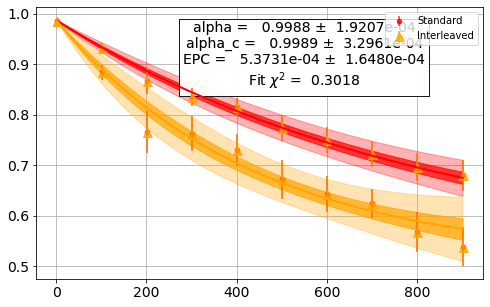

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.4754273517450079, 0.99881517621481, 0.9989253746762184, 0.5113287129609366]
- χ²: 0.30178101976322436
- quality: good
- extra: <4 items>
- device_components: ['Q3']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.99882+/-0.00019
- χ²: 0.30178101976322436
- quality: good
- extra: <1 items>
- device_components: ['Q3']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.99893+/-0.00033
- χ²: 0.30178101976322436
- quality: good
- extra: <1 items>
- device_components: ['Q3']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.00054+/-0.00016
- χ²: 0.30178101976322436
- quality: good
- extra: <3 items>
- device_components: ['Q3']
- verified: False
CLE is 0.00018934437816878202 at 2022-06-04 17:04:48.921155


In [10]:
lengths = np.arange(1, 1000, 100)
num_samples = 10
seed = 1010
qubits = [3]
print(backend)
print('delay_q3')
print(datetime.today())

duration=backend.properties().gate_length('x',3)/backend.configuration().dt
interleaved_element = Delay(duration, unit="dt")
int_exp1 = InterleavedRB(interleaved_element, qubits, lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata1 = int_exp1.run(backend, shots=1000).block_for_results()
int_results1 = int_expdata1.analysis_results()
# View result data
display(int_expdata1.figure(0))
for result in int_results1:
    print(result)
date = datetime.today()
CLE=RBUtils.coherence_limit(nQ=1, T1_list=[backend.properties(datetime=date).t1(3)],
T2_list=[backend.properties(datetime=date).t2(3)], gatelen=backend.properties(datetime=date).gate_length('x',(3)))
print(f"CLE is {CLE} at {date}")

ibm_nairobi
delay_q4
2022-06-04 17:10:53.286186


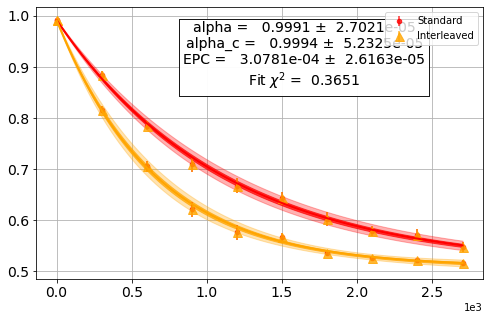

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.48311149711463336, 0.9991002360440787, 0.9993843832376511, 0.5084530903589005]
- χ²: 0.3650874115667863
- quality: good
- extra: <4 items>
- device_components: ['Q4']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.999100+/-0.000027
- χ²: 0.3650874115667863
- quality: good
- extra: <1 items>
- device_components: ['Q4']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.99938+/-0.00005
- χ²: 0.3650874115667863
- quality: good
- extra: <1 items>
- device_components: ['Q4']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.000308+/-0.000026
- χ²: 0.3650874115667863
- quality: good
- extra: <3 items>
- device_components: ['Q4']
- verified: False
CLE is 0.0001712209502058859 at 2022-06-04 17:19:39.253905


In [12]:
lengths = np.arange(1, 3000, 300)
num_samples = 10
seed = 1010
qubits = [4]
print(backend)
print('delay_q4')
print(datetime.today())

duration=backend.properties().gate_length('x',4)/backend.configuration().dt
interleaved_element = Delay(duration, unit="dt")
int_exp1 = InterleavedRB(interleaved_element, qubits, lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata1 = int_exp1.run(backend, shots=1000).block_for_results()
int_results1 = int_expdata1.analysis_results()
# View result data
display(int_expdata1.figure(0))
for result in int_results1:
    print(result)
date = datetime.today()
CLE=RBUtils.coherence_limit(nQ=1, T1_list=[backend.properties(datetime=date).t1(4)],
T2_list=[backend.properties(datetime=date).t2(4)], gatelen=backend.properties(datetime=date).gate_length('x',(4)))
print(f"CLE is {CLE} at {date}")

ibm_nairobi
delay_q5
2022-06-04 17:20:44.988312


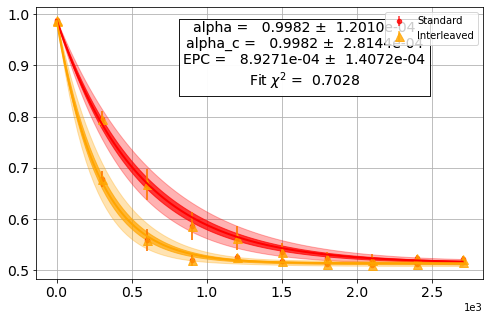

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.475317618645135, 0.9981525631597691, 0.9982145807117091, 0.5132882237200639]
- χ²: 0.7027612071471392
- quality: good
- extra: <4 items>
- device_components: ['Q5']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.99815+/-0.00012
- χ²: 0.7027612071471392
- quality: good
- extra: <1 items>
- device_components: ['Q5']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.99821+/-0.00028
- χ²: 0.7027612071471392
- quality: good
- extra: <1 items>
- device_components: ['Q5']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.00089+/-0.00014
- χ²: 0.7027612071471392
- quality: good
- extra: <3 items>
- device_components: ['Q5']
- verified: False
CLE is 0.0002303858553713567 at 2022-06-04 17:29:19.307093


In [13]:
lengths = np.arange(1, 3000, 300)
num_samples = 10
seed = 1010
qubits = [5]
print(backend)
print('delay_q5')
print(datetime.today())

duration=backend.properties().gate_length('x',5)/backend.configuration().dt
interleaved_element = Delay(duration, unit="dt")
int_exp1 = InterleavedRB(interleaved_element, qubits, lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata1 = int_exp1.run(backend, shots=1000).block_for_results()
int_results1 = int_expdata1.analysis_results()
# View result data
display(int_expdata1.figure(0))
for result in int_results1:
    print(result)
date = datetime.today()
CLE=RBUtils.coherence_limit(nQ=1, T1_list=[backend.properties(datetime=date).t1(5)],
T2_list=[backend.properties(datetime=date).t2(5)], gatelen=backend.properties(datetime=date).gate_length('x',(5)))
print(f"CLE is {CLE} at {date}")

ibm_nairobi
delay_q6
2022-06-04 17:30:53.532295


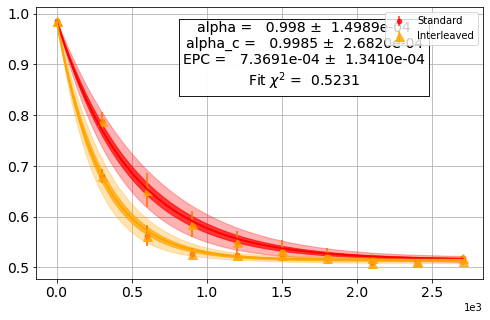

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.47192282025748516, 0.9979828468644891, 0.9985261871759066, 0.5145558968470523]
- χ²: 0.5230629375282411
- quality: good
- extra: <4 items>
- device_components: ['Q5']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.99798+/-0.00015
- χ²: 0.5230629375282411
- quality: good
- extra: <1 items>
- device_components: ['Q5']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.99853+/-0.00027
- χ²: 0.5230629375282411
- quality: good
- extra: <1 items>
- device_components: ['Q5']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.00074+/-0.00013
- χ²: 0.5230629375282411
- quality: good
- extra: <3 items>
- device_components: ['Q5']
- verified: False
CLE is 0.00015236744661217827 at 2022-06-04 17:42:41.536624


In [14]:
lengths = np.arange(1, 3000, 300)
num_samples = 10
seed = 1010
qubits = [6]
print(backend)
print('delay_q6')
print(datetime.today())

duration=backend.properties().gate_length('x',6)/backend.configuration().dt
interleaved_element = Delay(duration, unit="dt")
int_exp1 = InterleavedRB(interleaved_element, qubits, lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata1 = int_exp1.run(backend, shots=1000).block_for_results()
int_results1 = int_expdata1.analysis_results()
# View result data
display(int_expdata1.figure(0))
for result in int_results1:
    print(result)
date = datetime.today()
CLE=RBUtils.coherence_limit(nQ=1, T1_list=[backend.properties(datetime=date).t1(6)],
T2_list=[backend.properties(datetime=date).t2(6)], gatelen=backend.properties(datetime=date).gate_length('x',(6)))
print(f"CLE is {CLE} at {date}")